In [ ]:
!pip install category_encoders


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 4.5 MB/s eta 0:00:00


In [ ]:

import shap
%matplotlib inline
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
pd.set_option('display.max_columns',50)

from xgboost import XGBRegressor
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, LinearRegression
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score, validation_curve, GridSearchCV
from sklearn.metrics import (
    roc_curve,
    RocCurveDisplay,
    mean_absolute_error,
    mean_squared_error,
    accuracy_score
)


# Warnings Ignore
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Read in data
df = pd.read_csv('/content/energy_dataset.csv')

# Preview of data
df.head(5)

,time,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
0,2015-01-01 00:00:00+01:00,447.0,329.0,0.0,4844.0,4821.0,162.0,0.0,0.0,0.0,NaN,863.0,1051.0,1899.0,0.0,7096.0,43.0,73.0,49.0,196.0,0.0,6378.0,17,NaN,6436,26118,25385.0,50.10,65.41
1,2015-01-01 01:00:00+01:00,449.0,328.0,0.0,5196.0,4755.0,158.0,0.0,0.0,0.0,NaN,920.0,1009.0,1658.0,0.0,7096.0,43.0,71.0,50.0,195.0,0.0,5890.0,16,NaN,5856,24934,24382.0,48.10,64.92
2,2015-01-01 02:00:00+01:00,448.0,323.0,0.0,4857.0,4581.0,157.0,0.0,0.0,0.0,NaN,1164.0,973.0,1371.0,0.0,7099.0,43.0,73.0,50.0,196.0,0.0,5461.0,8,NaN,5454,23515,22734.0,47.33,64.48
3,2015-01-01 03:00:00+01:00,438.0,254.0,0.0,4314.0,4131.0,160.0,0.0,0.0,0.0,NaN,1503.0,949.0,779.0,0.0,7098.0,43.0,75.0,50.0,191.0,0.0,5238.0,2,NaN,5151,22642,21286.0,42.27,59.32
4,2015-01-01 04:00:00+01:00,428.0,187.0,0.0,4130.0,3840.0,156.0,0.0,0.0,0.0,NaN,1826.0,953.0,720.0,0.0,7097.0,43.0,74.0,42.0,189.0,0.0,4935.0,9,NaN,4861,21785,20264.0,38.41,56.04


In [ ]:
df.describe()

,generation biomass,generation fossil brown coal/lignite,generation fossil coal-derived gas,generation fossil gas,generation fossil hard coal,generation fossil oil,generation fossil oil shale,generation fossil peat,generation geothermal,generation hydro pumped storage aggregated,generation hydro pumped storage consumption,generation hydro run-of-river and poundage,generation hydro water reservoir,generation marine,generation nuclear,generation other,generation other renewable,generation solar,generation waste,generation wind offshore,generation wind onshore,forecast solar day ahead,forecast wind offshore eday ahead,forecast wind onshore day ahead,total load forecast,total load actual,price day ahead,price actual
count,35045.000000,35046.000000,35046.0,35046.000000,35046.000000,35045.000000,35046.0,35046.0,35046.0,0.0,35045.000000,35045.000000,35046.000000,35045.0,35047.000000,35046.000000,35046.000000,35046.000000,35045.000000,35046.0,35046.000000,35064.000000,0.0,35064.000000,35064.000000,35028.000000,35064.000000,35064.000000
mean,383.513540,448.059208,0.0,5622.737488,4256.065742,298.319789,0.0,0.0,0.0,NaN,475.577343,972.116108,2605.114735,0.0,6263.907039,60.228585,85.639702,1432.665925,269.452133,0.0,5464.479769,1439.066735,NaN,5471.216689,28712.129962,28696.939905,49.874341,57.884023
std,85.353943,354.568590,0.0,2201.830478,1961.601013,52.520673,0.0,0.0,0.0,NaN,792.406614,400.777536,1835.199745,0.0,839.667958,20.238381,14.077554,1680.119887,50.195536,0.0,3213.691587,1677.703355,NaN,3176.312853,4594.100854,4574.987950,14.618900,14.204083
min,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,NaN,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,NaN,237.000000,18105.000000,18041.000000,2.060000,9.330000
25%,333.000000,0.000000,0.0,4126.000000,2527.000000,263.000000,0.0,0.0,0.0,NaN,0.000000,637.000000,1077.250000,0.0,5760.000000,53.000000,73.000000,71.000000,240.000000,0.0,2933.000000,69.000000,NaN,2979.000000,24793.750000,24807.750000,41.490000,49.347500
50%,367.000000,509.000000,0.0,4969.000000,4474.000000,300.000000,0.0,0.0,0.0,NaN,68.000000,906.000000,2164.000000,0.0,6566.000000,57.000000,88.000000,616.000000,279.000000,0.0,4849.000000,576.000000,NaN,4855.000000,28906.000000,28901.000000,50.520000,58.020000
75%,433.000000,757.000000,0.0,6429.000000,5838.750000,330.000000,0.0,0.0,0.0,NaN,616.000000,1250.000000,3757.000000,0.0,7025.000000,80.000000,97.000000,2578.000000,310.000000,0.0,7398.000000,2636.000000,NaN,7353.000000,32263.250000,32192.000000,60.530000,68.010000
max,592.000000,999.000000,0.0,20034.000000,8359.000000,449.000000,0.0,0.0,0.0,NaN,4523.000000,2000.000000,9728.000000,0.0,7117.000000,106.000000,119.000000,5792.000000,357.000000,0.0,17436.000000,5836.000000,NaN,17430.000000,41390.000000,41015.000000,101.990000,116.800000


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35064 entries, 0 to 35063
Data columns (total 29 columns):
 #   Column                                       Non-Null Count  Dtype  
---  ------                                       --------------  -----  
 0   time                                         35064 non-null  object 
 1   generation biomass                           35045 non-null  float64
 2   generation fossil brown coal/lignite         35046 non-null  float64
 3   generation fossil coal-derived gas           35046 non-null  float64
 4   generation fossil gas                        35046 non-null  float64
 5   generation fossil hard coal                  35046 non-null  float64
 6   generation fossil oil                        35045 non-null  float64
 7   generation fossil oil shale                  35046 non-null  float64
 8   generation fossil peat                       35046 non-null  float64
 9   generation geothermal                        35046 non-null  float64
 10

In [ ]:
round((df.isnull().sum()/len(df)*100),2)

,0
time,0.00
generation biomass,0.05
generation fossil brown coal/lignite,0.05
generation fossil coal-derived gas,0.05
generation fossil gas,0.05
generation fossil hard coal,0.05
generation fossil oil,0.05
generation fossil oil shale,0.05
generation fossil peat,0.05
generation geothermal,0.05


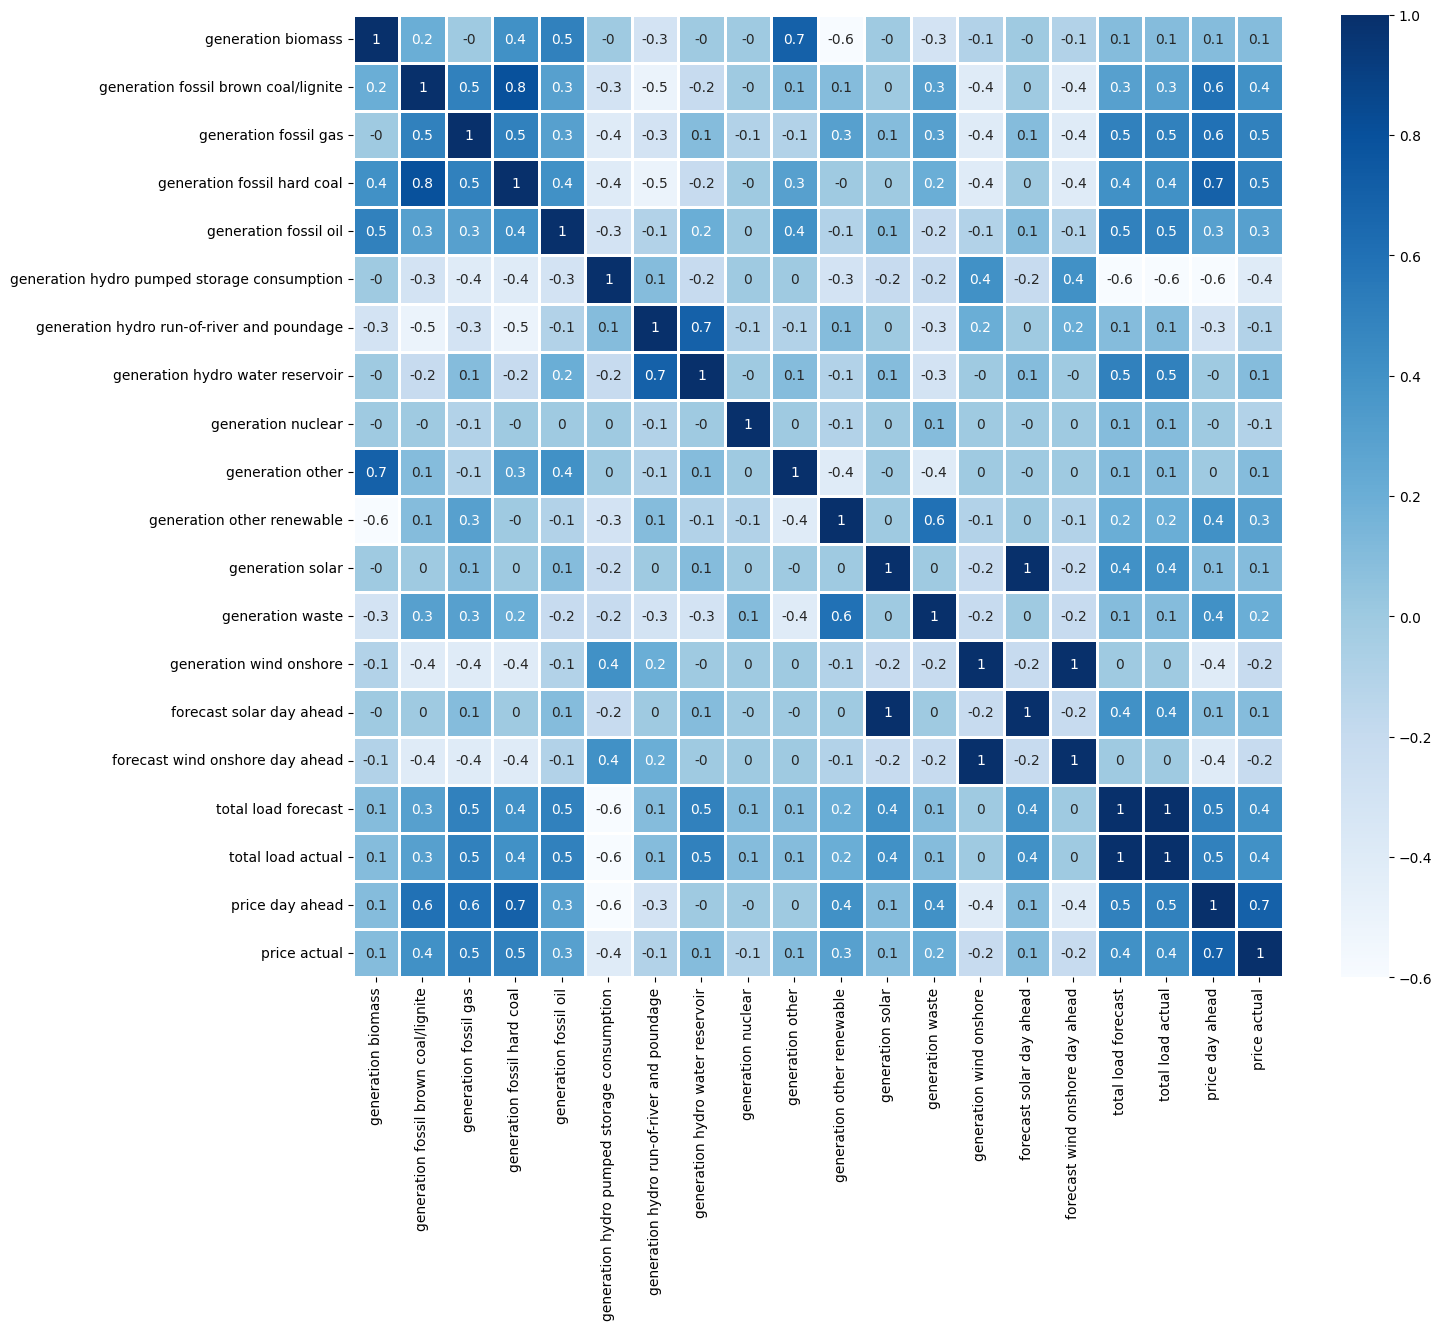

In [ ]:
# Drop zero-valued columns
zero_val_cols = ['generation marine',
                 'generation geothermal',
                 'generation fossil peat',
                 'generation wind offshore',
                 'generation fossil oil shale',
                 'forecast wind offshore eday ahead',
                 'generation fossil coal-derived gas',
                 'generation hydro pumped storage aggregated']

# Drop zero-value and non-numeric columns
heat_map_features = df.drop(columns=zero_val_cols, axis=1)

# Select only numeric columns for correlation
numeric_features = heat_map_features.select_dtypes(include=['number'])

# Plot heatmap
plt.figure(figsize=(15, 12.5))
sns.heatmap(round(numeric_features.corr(), 1), annot=True, cmap='Blues', linewidth=0.9)
plt.show()


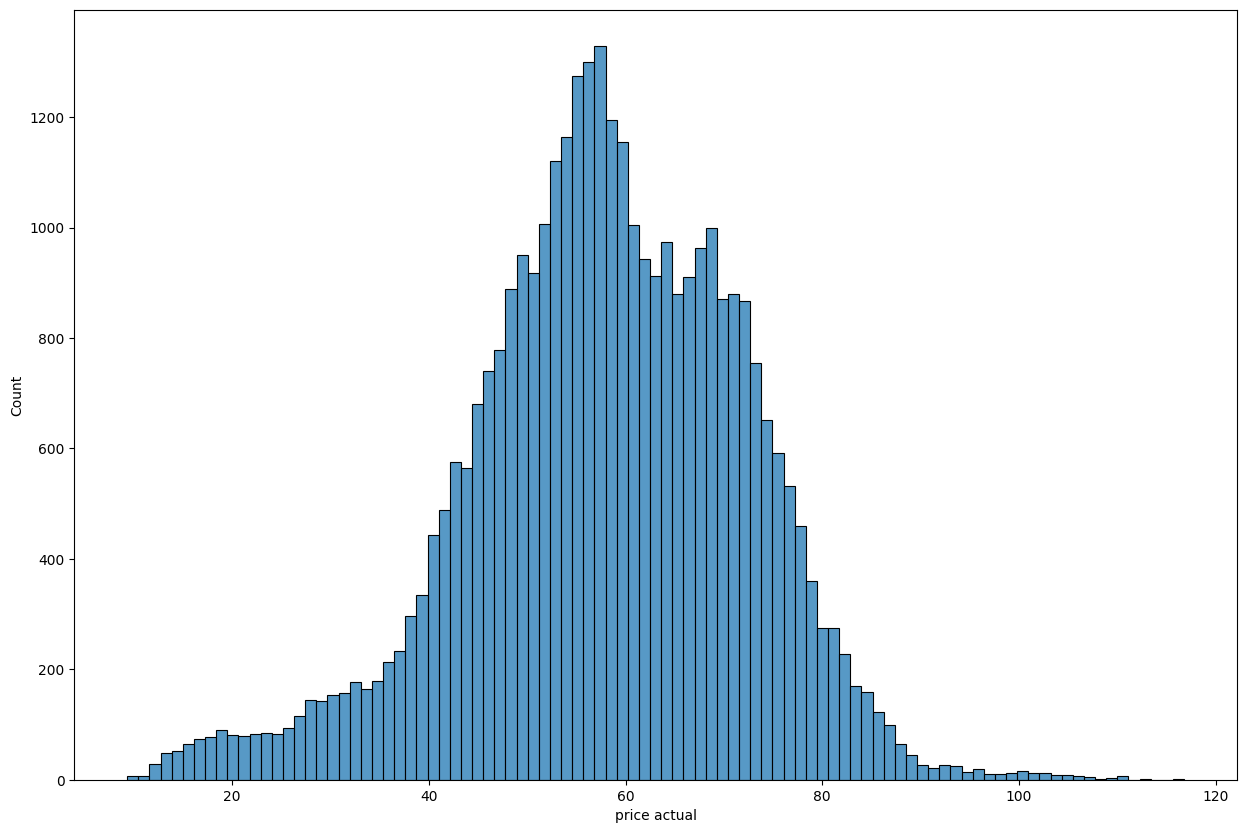

In [ ]:
# Figure Size
plt.figure(figsize=(15,10))

# Hist graph to show distribution of target variable
sns.histplot(df,x='price actual');

DATA WRANGLING

The wrangle(filepath) function processes a CSV file containing time-series energy data. It performs the following steps:

Load & Clean Data: Reads the CSV file, parses the 'time' column as a datetime index, and standardizes column names by replacing spaces and hyphens with underscores.

Drop Unnecessary Columns: Removes irrelevant or redundant features to focus on essential data.

Ensure Chronological Order: Converts the index to UTC format and sorts the data by time.

Handle Specific Data Issues: Drops a particular timestamp (2014-12-31 23:00:00+00:00) that may contain missing or erroneous data.

Add a 'Season' Column: Categorizes each timestamp into one of four seasons (winter, spring, summer, autumn) based on the month.

In [ ]:
def wrangle(filepath):




    df = pd.read_csv(filepath, parse_dates=['time'], index_col='time')


    df.columns = df.columns.str.replace(' ', '_').str.replace('-', '_')


    df.index = pd.to_datetime(df.index, utc=True)


    df.drop(columns=[
        'price_day_ahead',
        'generation_marine',
        'total_load_forecast',
        'generation_geothermal',
        'generation_fossil_peat',
        'generation_wind_offshore',
        'forecast_solar_day_ahead',
        'generation_fossil_oil_shale',
        'forecast_wind_onshore_day_ahead',
        'forecast_wind_offshore_eday_ahead',
        'generation_fossil_coal_derived_gas',
        'generation_hydro_pumped_storage_aggregated'
    ], inplace=True)


    df = df.drop(pd.Timestamp('2014-12-31 23:00:00+00:00'))


    df = df.sort_index()


    condition_winter = (df.index.month >= 1) & (df.index.month <= 3)
    condition_spring = (df.index.month >= 4) & (df.index.month <= 6)
    condition_summer = (df.index.month >= 7) & (df.index.month <= 9)
    condition_autumn = (df.index.month >= 10) & (df.index.month <= 12)


    df['season'] = np.where(condition_winter, 'winter',
                     np.where(condition_spring, 'spring',
                     np.where(condition_summer, 'summer',
                     np.where(condition_autumn, 'autumn', 'unknown'))))

    return df


In [ ]:
df = wrangle('/content/energy_dataset.csv')


In [ ]:
# Figure showing Price per total load
fig = px.scatter(df,x='total_load_actual',
                 y='price_actual',
                 facet_col='season',
                 opacity=0.1,
                 title='Price Per KW Hour Compaired To Total Energy Genereated Per Season',
                 animation_frame=df.index.year)

# Figure customizations
fig.update_traces(marker=dict(size=12,
                              line=dict(width=2,
                                        color='darkslateblue')),
                  selector=dict(mode='markers'))

In [ ]:

target='price_actual'


y,X=df[target],df.drop(columns=target)


X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=.2,random_state=42)

This code performs preprocessing on the training (X_train) and validation (X_val) datasets by applying one-hot encoding and imputation:

One-Hot Encoding: The OneHotEncoder transforms the categorical 'season' column into multiple binary columns (e.g., season_winter, season_spring, etc.).

The encoder is fitted on X_train and then applied to both X_train and X_val, creating XT_train and XT_val.

Handling Missing Values: The SimpleImputer replaces any missing values in the dataset using the mean strategy.

It is first fitted on XT_train and then used to transform both XT_train and XT_val.

In [ ]:
# One Hot Encoder to transform Seasons column
onehot = OneHotEncoder(use_cat_names=True)
onehot_fit = onehot.fit(X_train)
XT_train = onehot.transform(X_train)
XT_val = onehot.transform(X_val)

# Simple imputer to fill nan values, then transform sets
simp = SimpleImputer(strategy='mean')
simp_fit = simp.fit(XT_train)
XT_train = simp.transform(XT_train)
XT_val = simp.transform(XT_val)



This code preprocesses the X_train and X_val datasets by applying ordinal encoding and imputation:

Ordinal Encoding: The OrdinalEncoder converts the categorical 'season' column into numerical values (e.g., 'winter' → 0, 'spring' → 1, etc.).

The encoder is first fitted on X_train and then transforms both X_train and X_val, creating XT_train and XT_val.

Handling Missing Values: The SimpleImputer fills any missing values with the mean of the respective column.

It is fitted on XT_train and then used to transform both XT_train and XT_val.

In [ ]:
# Ordinal Encoder to transform Seasons column
ordinal = OrdinalEncoder()
ordinal_fit = ordinal.fit(X_train)
XT_train = ordinal.transform(X_train)
XT_val = ordinal.transform(X_val)

# Simple imputer to fill nan values, then transform sets
simp = SimpleImputer(strategy='mean')
simp_fit = simp.fit(XT_train)
XT_train = simp.transform(XT_train)
XT_val = simp.transform(XT_val)



In [ ]:
# Install PyTorch Geometric and dependencies
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
!pip install torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-2.1.0+cu121.html


Looking in indexes: https://download.pytorch.org/whl/cu121
INFO: pip is looking at multiple versions of torch to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.5/780.5 MB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 101.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 124.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.0 MB/s e

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split


This code preprocesses the dataset for use in a Graph Neural Network (GNN) by performing the following steps:

Feature Selection: Drops the target variable (price_actual) and categorical column (season) to focus on numeric features.

Handling Missing Values: Uses forward fill (ffill) and backward fill (bfill) to fill any NaN values.

Feature Scaling: Applies StandardScaler to normalize the numeric features, ensuring they have a mean of 0 and a standard deviation of 1.

Encoding the 'Season' Column:

Uses LabelEncoder to convert categorical seasons (winter, spring, etc.) into numerical values.

Reshapes the encoded values into a column format for concatenation.

Feature Combination: Concatenates the scaled numerical features and the encoded season values into node_features.

Conversion to Tensors:

Converts node_features into a PyTorch tensor (x) for model input.

Converts price_actual (target variable) into a tensor (y), reshaped as a column vector.

In [ ]:
# Get numeric features
features = df.drop(columns=['price_actual', 'season'])  # Drop target and categorical for now

# Handle NaNs: Fill missing values (simple fill for now)
features = features.fillna(method='ffill').fillna(method='bfill')

# Scale features
scaler = StandardScaler()
x = scaler.fit_transform(features.values)

# Encode 'season' and concatenate with features
le = LabelEncoder()
season_encoded = le.fit_transform(df['season'])
season_encoded = season_encoded.reshape(-1, 1)

# Combine all node features
node_features = np.hstack([x, season_encoded])

# Convert to tensor
x = torch.tensor(node_features, dtype=torch.float)

# Target: price_actual
y = torch.tensor(df['price_actual'].values, dtype=torch.float).view(-1, 1)


In [ ]:
!pip install torch torchvision torchaudio torch-geometric

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np


In [ ]:
print(X_train.select_dtypes(include=['object']).columns)


Index(['season'], dtype='object')


In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error

df = pd.read_csv('/content/energy_dataset.csv')
df = df.dropna(subset=["price actual"])

y_true = df["price actual"].values
baseline_prediction = df["price actual"].mean()
y_pred = np.full_like(y_true, fill_value=baseline_prediction)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
mae = mean_absolute_error(y_true, y_pred)

print(f"Baseline RMSE: {rmse:.2f}")
print(f"Baseline MAE: {mae:.2f}")


Base RMSE is 14.20
Base MAE is 11.09


Graph Convolutional Network (GCN)

A Graph Convolutional Network (GCN) is a deep learning model designed to operate on graph-structured data. Unlike traditional neural networks that work with grid-like data (e.g., images, text), GCNs capture node relationships and graph topology.

How GCN Works
Message Passing: Each node gathers information from its neighbors to update its representation.

Aggregation: Neighboring node features are combined (e.g., using sum, mean, or weighted sum).

Transformation: The aggregated features are passed through a neural network (typically a linear transformation + non-linearity like ReLU).

Propagation: This process is repeated for multiple layers, allowing information to spread across the graph.

In [ ]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd

# One-Hot Encode 'season' if it still exists
if 'season' in X_train.columns:
    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

    # Fit encoder on training set
    season_encoded_train = encoder.fit_transform(X_train[['season']])
    season_encoded_val = encoder.transform(X_val[['season']])

    # Convert to DataFrame
    season_cols = [f'season_{i}' for i in range(season_encoded_train.shape[1])]
    season_df_train = pd.DataFrame(season_encoded_train, columns=season_cols, index=X_train.index)
    season_df_val = pd.DataFrame(season_encoded_val, columns=season_cols, index=X_val.index)

    # Drop 'season' and add encoded values
    X_train = X_train.drop(columns=['season']).reset_index(drop=True)
    X_val = X_val.drop(columns=['season']).reset_index(drop=True)

    X_train = pd.concat([X_train.reset_index(drop=True), season_df_train.reset_index(drop=True)], axis=1)
    X_val = pd.concat([X_val.reset_index(drop=True), season_df_val.reset_index(drop=True)], axis=1)

# Convert all column names to strings (avoid type errors)
X_train.columns = X_train.columns.astype(str)
X_val.columns = X_val.columns.astype(str)

# Ensure no NaNs remain
imputer = SimpleImputer(strategy='mean')
X_train = pd.DataFrame(imputer.fit_transform(X_train), columns=X_train.columns)
X_val = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

# Now pass the cleaned data to create_graph()
data_train, scaler = create_graph(X_train, y_train)
data_val, _ = create_graph(X_val, y_val)


In [ ]:
def create_graph(X_train, y_train):
    num_nodes = X_train.shape[0]

    # Feature Scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)

    # Convert features to PyTorch tensors
    x = torch.tensor(X_train_scaled, dtype=torch.float)
    y = torch.tensor(y_train.values, dtype=torch.float).view(-1, 1)  # Target

    # Construct an edge index (e.g., k-nearest neighbors or temporal edges)
    edge_index = torch.tensor(
        np.array([[i, i+1] for i in range(num_nodes-1)]).T, dtype=torch.long
    )

    data = Data(x=x, edge_index=edge_index, y=y)
    return data, scaler

# Prepare Graph Data
data_train, scaler = create_graph(X_train, y_train)
data_val, _ = create_graph(X_val, y_val)


In [ ]:
class GCNRegressor(nn.Module):
    def __init__(self, input_dim):
        super(GCNRegressor, self).__init__()
        self.conv1 = GCNConv(input_dim, 64)
        self.conv2 = GCNConv(64, 32)
        self.fc = nn.Linear(32, 1)
        self.dropout = nn.Dropout(0.3)  # Prevent overfitting
        self.batch_norm1 = nn.BatchNorm1d(64)
        self.batch_norm2 = nn.BatchNorm1d(32)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = self.batch_norm1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.batch_norm2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.fc(x)
        return x



In [ ]:
def train_model(model, data, epochs=500, lr=0.01):
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=5e-4)
    criterion = nn.MSELoss()

    for epoch in range(epochs):
        model.train()
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item():.4f}')


In [ ]:
def evaluate_model(model, data):
    model.eval()
    with torch.no_grad():
        predictions = model(data).squeeze().cpu().numpy()
        actuals = data.y.squeeze().cpu().numpy()

        rmse = np.sqrt(mean_squared_error(actuals, predictions))
        mae = mean_absolute_error(actuals, predictions)

        print(f'RMSE: {rmse:.4f}')
        print(f'MAE: {mae:.4f}')

    return rmse, mae


In [ ]:
# Initialize Model
model = GCNRegressor(input_dim=X_train.shape[1])

# Train Model
train_model(model, data_train, epochs=500, lr=0.01)

# Evaluate Model
rmse, mae = evaluate_model(model, data_val)


Epoch 0, Loss: 3533.3730
Epoch 50, Loss: 1947.3489
Epoch 100, Loss: 291.3338
Epoch 150, Loss: 239.7220
Epoch 200, Loss: 238.6717
Epoch 250, Loss: 231.6247
Epoch 300, Loss: 228.3923
Epoch 350, Loss: 226.8440
Epoch 400, Loss: 225.9393
Epoch 450, Loss: 223.8601
RMSE: 13.6469
MAE: 10.7910


In [ ]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import numpy as np

# Handle missing values
imputer = SimpleImputer(strategy="mean")
X_train = imputer.fit_transform(X_train)
X_val = imputer.transform(X_val)

# Normalize features (important for GCN stability)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)


In [ ]:
import torch
import torch_geometric
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph

def create_graph(X, y, k=5):
    X = torch.tensor(X, dtype=torch.float32)
    y = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

    # kNN Graph Construction (Adjacency Matrix)
    adj_matrix = kneighbors_graph(X, k, mode='connectivity', include_self=True)
    edge_index = torch.tensor(adj_matrix.nonzero(), dtype=torch.long)

    return Data(x=X, edge_index=edge_index, y=y)

data_train = create_graph(X_train, y_train, k=5)
data_val = create_graph(X_val, y_val, k=5)


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, BatchNorm

class GCN(nn.Module):
    def __init__(self, in_features, hidden_dim=64, dropout=0.3):
        super(GCN, self).__init__()

        self.conv1 = GCNConv(in_features, hidden_dim)
        self.bn1 = BatchNorm(hidden_dim)  # Batch Normalization
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        self.bn2 = BatchNorm(hidden_dim)
        self.conv3 = GCNConv(hidden_dim, 1)  # Output layer

        self.dropout = nn.Dropout(dropout)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)  # Regression Output
        return x.view(-1)


In [ ]:
model = GCN(in_features=X_train.shape[1], hidden_dim=128, dropout=0.3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=5e-4)
criterion = nn.SmoothL1Loss()  # More stable than MSELoss


In [ ]:
def train(model, data, optimizer, criterion, epochs=500):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

train(model, data_train, optimizer, criterion)


Epoch 0, Loss: 58.5012
Epoch 50, Loss: 54.1489
Epoch 100, Loss: 49.7872
Epoch 150, Loss: 44.8485
Epoch 200, Loss: 39.0679
Epoch 250, Loss: 32.3144
Epoch 300, Loss: 25.1839
Epoch 350, Loss: 19.3015
Epoch 400, Loss: 14.3508
Epoch 450, Loss: 12.7438


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        y_pred = model(data).cpu().numpy()
        y_true = data.y.cpu().numpy()

        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)

        return rmse, mae

rmse, mae = evaluate(model, data_val)
print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")


RMSE: 3.57
MAE: 2.86


GraphSAGE (Graph Sample and Aggregation)

GraphSAGE is a Graph Neural Network (GNN) that efficiently learns node embeddings by sampling and aggregating information from a node’s neighbors. Unlike GCN, which processes the entire graph at once, GraphSAGE samples a fixed number of neighbors per node, making it scalable to large graphs.

How GraphSAGE Works
Neighbor Sampling: Instead of using all neighbors, GraphSAGE randomly samples a fixed number of neighbors for each node.

Feature Aggregation: Aggregates neighbor information using functions like mean, LSTM, or pooling.

Feature Update: The node’s representation is updated based on the aggregated neighbor features.

Propagation: The process repeats across multiple layers to capture higher-order relationships.

Key Advantages Over GCN
Scalability: Works well on large graphs by limiting the number of neighbors processed.

Inductive Learning: Can generalize to unseen nodes, unlike GCN, which requires all nodes during training.

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np


In [ ]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(input_dim, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x.squeeze()


In [ ]:
def create_graph(X, y):
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    x = torch.tensor(X_scaled, dtype=torch.float)
    y = torch.tensor(y.values, dtype=torch.float)

    edge_index = torch.randint(0, X.shape[0], (2, X.shape[0] * 2))  # Random graph structure

    data = Data(x=x, edge_index=edge_index, y=y)
    return data, scaler


In [ ]:
def train(model, data, optimizer, criterion, epochs=500):
    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, data.y)
        loss.backward()
        optimizer.step()

        if epoch % 50 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


In [ ]:
def evaluate(model, data):
    model.eval()
    with torch.no_grad():
        preds = model(data)
        rmse = np.sqrt(mean_squared_error(data.y.numpy(), preds.numpy()))
        mae = mean_absolute_error(data.y.numpy(), preds.numpy())
    return rmse, mae


In [ ]:
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 1

# Prepare graph data
data_train, scaler = create_graph(X_train, y_train)
data_val, _ = create_graph(X_val, y_val)

# Initialize model, optimizer, and loss function
model = GraphSAGE(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.MSELoss()

# Train the model
train(model, data_train, optimizer, criterion, epochs=500)

# Evaluate on validation set
rmse, mae = evaluate(model, data_val)
print(f"Final RMSE: {rmse:.4f}, MAE: {mae:.4f}")


Epoch 0, Loss: 3276.5835
Epoch 50, Loss: 2981.8728
Epoch 100, Loss: 2437.3672
Epoch 150, Loss: 1622.7137
Epoch 200, Loss: 866.3514
Epoch 250, Loss: 472.4060
Epoch 300, Loss: 360.7034
Epoch 350, Loss: 327.1528
Epoch 400, Loss: 305.8866
Epoch 450, Loss: 288.3075
Final RMSE: 16.7948, MAE: 12.7447


Epoch 000, Loss: 2612.3022, RMSE: 57.0226, MAE: 55.2140
Epoch 010, Loss: 226.1468, RMSE: 16.7126, MAE: 13.4846
Epoch 020, Loss: 259.6722, RMSE: 17.9179, MAE: 14.1541
Epoch 030, Loss: 140.4349, RMSE: 13.1515, MAE: 10.3247
Epoch 040, Loss: 132.2834, RMSE: 12.7604, MAE: 10.1016
Epoch 050, Loss: 112.6703, RMSE: 11.7718, MAE: 9.0517
Epoch 060, Loss: 110.5871, RMSE: 11.6620, MAE: 8.9264
Epoch 070, Loss: 108.2341, RMSE: 11.5358, MAE: 8.8705
Epoch 080, Loss: 103.3118, RMSE: 11.2682, MAE: 8.6667
Epoch 090, Loss: 102.2267, RMSE: 11.2087, MAE: 8.5952
Epoch 100, Loss: 99.2720, RMSE: 11.0438, MAE: 8.4955
Epoch 110, Loss: 98.5593, RMSE: 11.0040, MAE: 8.4417
Epoch 120, Loss: 97.2997, RMSE: 10.9328, MAE: 8.3919
Epoch 130, Loss: 97.0815, RMSE: 10.9205, MAE: 8.3768
Epoch 140, Loss: 95.7470, RMSE: 10.8450, MAE: 8.2796
Epoch 150, Loss: 96.4188, RMSE: 10.8828, MAE: 8.3532
Epoch 160, Loss: 94.5498, RMSE: 10.7765, MAE: 8.2167
Epoch 170, Loss: 95.5270, RMSE: 10.8322, MAE: 8.2860
Epoch 180, Loss: 94.5414, RMSE

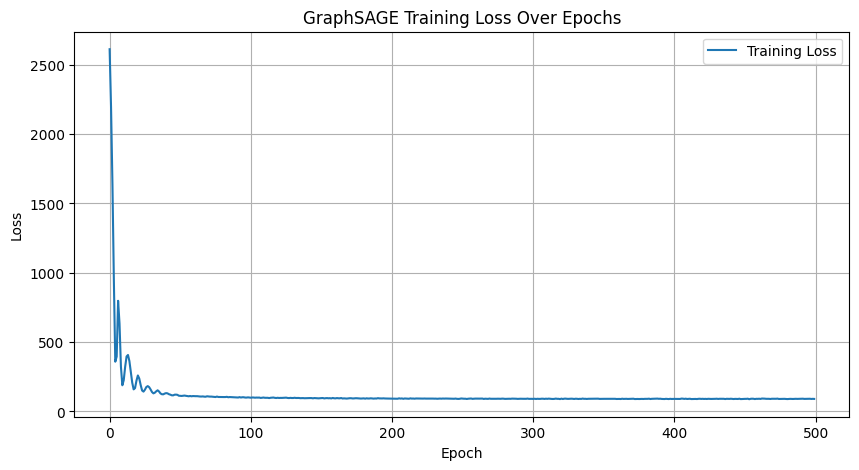

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import SAGEConv
from torch_geometric.data import Data
from sklearn.neighbors import kneighbors_graph
import numpy as np
import matplotlib.pyplot as plt  # Added for plotting

# Set k for k-NN graph construction
k = 5

# Construct adjacency matrix using k-NN
adj_matrix = kneighbors_graph(node_features, k, mode='connectivity', include_self=True)

# Convert adjacency matrix to edge index format
edge_index = torch.tensor(np.array(adj_matrix.nonzero()), dtype=torch.long)

# Convert node features (X) and target (y) to PyG Data object
data = Data(x=x, edge_index=edge_index, y=y)

# Define Optimized GraphSAGE model
class GraphSAGE(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GraphSAGE, self).__init__()
        self.conv1 = SAGEConv(in_channels, hidden_channels)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)
        self.conv3 = SAGEConv(hidden_channels, out_channels)
        self.dropout = torch.nn.Dropout(0.4)  # Increased dropout for regularization

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.dropout(x)
        x = self.conv3(x, edge_index)
        return x

# Initialize model, optimizer, and loss function
model = GraphSAGE(in_channels=x.shape[1], hidden_channels=128, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)

# Loss functions
mse_loss = torch.nn.MSELoss()
mae_loss = torch.nn.L1Loss()

# Track loss over epochs
loss_history = []

# Training loop
epochs = 500
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)

    # Combined loss: 80% MSE + 20% MAE
    loss = 0.8 * mse_loss(out, data.y) + 0.2 * mae_loss(out, data.y)
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Store loss
    loss_history.append(loss.item())

    # Calculate RMSE and MAE
    rmse = torch.sqrt(mse_loss(out, data.y)).item()
    mae = mae_loss(out, data.y).item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print("Training Complete!")

# Plot training loss
plt.figure(figsize=(10, 5))
plt.plot(loss_history, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('GraphSAGE Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Physics-Informed Neural Networks (PINNs)

Physics-Informed Neural Networks (PINNs) are a type of deep learning model that integrates physical laws (governed by differential equations) into neural network training. Instead of relying only on labeled data, PINNs use physics-based constraints to improve generalization and accuracy.

How PINNs Work
Neural Network Approximation: A standard neural network approximates the solution to a physical system.

Physics Constraints: Instead of optimizing only for data loss, PINNs also minimize residual errors from governing equations (e.g., partial differential equations, PDEs).

Hybrid Loss Function: The total loss is a combination of:

Data loss (difference between predicted and observed values)

Physics loss (ensuring the solution satisfies known physical equations)

Training & Optimization: The network is trained using gradient-based optimizers (e.g., Adam, LBFGS).

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

# Define the PINN model
class PINN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize model
input_dim = x.shape[1]  # Number of input features
model = PINN(input_dim=input_dim)

# Optimizer and loss functions
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.5)
mse_loss = nn.MSELoss()

# Physics-Informed Loss function
def physics_loss(model, x, y):
    x.requires_grad = True  # Enable gradients for autograd
    P_pred = model(x)  # Predict price

    # Compute dP/dt using autograd
    dP_dt = torch.autograd.grad(P_pred, x, grad_outputs=torch.ones_like(P_pred), create_graph=True)[0][:, 0]

    # Get demand, supply, and external factor (assuming first three columns)
    demand = x[:, 0]
    supply = x[:, 1]
    external_factor = x[:, 2]  # Adjust based on feature importance

    # Learnable coefficients (alpha, beta, gamma)
    alpha = torch.tensor(0.5, requires_grad=True)
    beta = torch.tensor(0.5, requires_grad=True)
    gamma = torch.tensor(0.5, requires_grad=True)

    physics_residual = dP_dt - (alpha * demand - beta * supply + gamma * external_factor)

    return torch.mean(physics_residual**2)

# Training loop
epochs = 500
lambda_data = 1.0  # Weight for data loss
lambda_physics = 0.1  # Weight for physics loss

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Predictions
    P_pred = model(x)

    # Compute losses
    loss_data = mse_loss(P_pred, y)
    loss_physics = physics_loss(model, x, y)

    # Total loss
    loss = lambda_data * loss_data + lambda_physics * loss_physics

    # Backpropagation
    loss.backward()
    optimizer.step()
    scheduler.step()

    # Compute RMSE and MAE
    rmse = torch.sqrt(loss_data).item()
    mae = torch.mean(torch.abs(P_pred - y)).item()

    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print("Training Complete!")


Epoch 000, Loss: 3540.6348, RMSE: 59.5029, MAE: 57.7670
Epoch 010, Loss: 2665.0813, RMSE: 51.6241, MAE: 49.5774
Epoch 020, Loss: 1975.1912, RMSE: 44.4427, MAE: 42.1281
Epoch 030, Loss: 1446.3906, RMSE: 38.0309, MAE: 35.4631
Epoch 040, Loss: 1041.0359, RMSE: 32.2645, MAE: 29.4869
Epoch 050, Loss: 745.5720, RMSE: 27.3045, MAE: 24.3651
Epoch 060, Loss: 635.3960, RMSE: 25.2063, MAE: 22.1929
Epoch 070, Loss: 546.1496, RMSE: 23.3690, MAE: 20.2863
Epoch 080, Loss: 472.9159, RMSE: 21.7458, MAE: 18.6077
Epoch 090, Loss: 412.9634, RMSE: 20.3206, MAE: 17.1502
Epoch 100, Loss: 364.3287, RMSE: 19.0864, MAE: 15.9033
Epoch 110, Loss: 344.0122, RMSE: 18.5466, MAE: 15.3627
Epoch 120, Loss: 326.0244, RMSE: 18.0551, MAE: 14.8739
Epoch 130, Loss: 309.9116, RMSE: 17.6032, MAE: 14.4279
Epoch 140, Loss: 295.4686, RMSE: 17.1881, MAE: 14.0195
Epoch 150, Loss: 282.5696, RMSE: 16.8087, MAE: 13.6488
Epoch 160, Loss: 276.7023, RMSE: 16.6332, MAE: 13.4782
Epoch 170, Loss: 271.1841, RMSE: 16.4665, MAE: 13.3165
Epoch

Epoch 000, Loss: 3253.8770, RMSE: 57.0411, MAE: 55.2214
Epoch 010, Loss: 291.9794, RMSE: 16.9822, MAE: 13.5746
Epoch 020, Loss: 426.3377, RMSE: 20.5899, MAE: 17.8004
Epoch 030, Loss: 262.3114, RMSE: 15.9497, MAE: 12.4243
Epoch 040, Loss: 180.9779, RMSE: 13.2971, MAE: 10.6724
Epoch 050, Loss: 138.4695, RMSE: 11.5537, MAE: 8.5980
Epoch 060, Loss: 129.6678, RMSE: 11.1929, MAE: 8.3549
Epoch 070, Loss: 123.3202, RMSE: 10.9554, MAE: 8.2753
Epoch 080, Loss: 116.6278, RMSE: 10.6569, MAE: 7.9472
Epoch 090, Loss: 112.7414, RMSE: 10.4888, MAE: 7.7912
Epoch 100, Loss: 109.2569, RMSE: 10.3346, MAE: 7.6834
Epoch 110, Loss: 106.5073, RMSE: 10.2081, MAE: 7.5865
Epoch 120, Loss: 104.0366, RMSE: 10.0902, MAE: 7.4893
Epoch 130, Loss: 101.7870, RMSE: 9.9809, MAE: 7.3987
Epoch 140, Loss: 99.6618, RMSE: 9.8769, MAE: 7.3151
Epoch 150, Loss: 97.5454, RMSE: 9.7722, MAE: 7.2346
Epoch 160, Loss: 95.3326, RMSE: 9.6623, MAE: 7.1506
Epoch 170, Loss: 93.1247, RMSE: 9.5506, MAE: 7.0629
Epoch 180, Loss: 90.9592, RMSE:

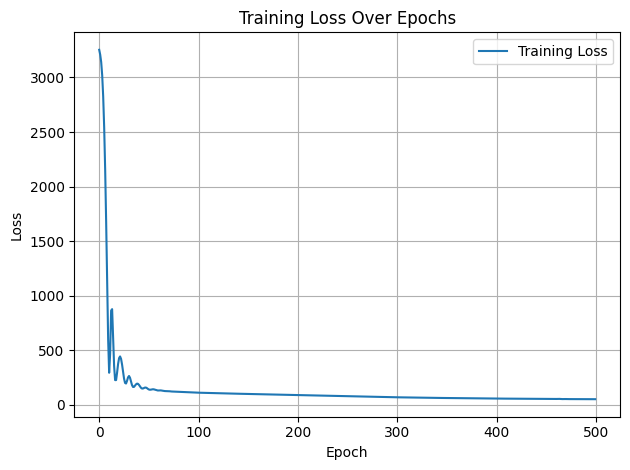

In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

# PINN Model
class ImprovedPINN(nn.Module):
    def __init__(self, input_dim, hidden_dim=128):
        super(ImprovedPINN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, 1)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        x = self.activation(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize
input_dim = x.shape[1]
model = ImprovedPINN(input_dim=input_dim)
optimizer = optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=20, verbose=True)
mse_loss = nn.MSELoss()

# Physics Loss
def physics_loss(model, x, y):
    x.requires_grad = True
    P_pred = model(x)
    dP_dt = torch.autograd.grad(P_pred, x, grad_outputs=torch.ones_like(P_pred), create_graph=True)[0][:, 0]
    demand = x[:, 0]
    supply = x[:, 1]
    external_factor = x[:, 2]
    alpha = nn.Parameter(torch.tensor(0.5, requires_grad=True))
    beta = nn.Parameter(torch.tensor(0.5, requires_grad=True))
    gamma = nn.Parameter(torch.tensor(0.5, requires_grad=True))
    physics_residual = dP_dt - (alpha * demand - beta * supply + gamma * external_factor)
    return torch.mean(physics_residual**2)

# Training loop
epochs = 500
lambda_data = 1.0
lambda_physics = 0.5
losses = []

for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    P_pred = model(x)
    loss_data = mse_loss(P_pred, y)
    loss_physics = physics_loss(model, x, y)
    loss = lambda_data * loss_data + lambda_physics * loss_physics
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    losses.append(loss.item())

    if epoch % 10 == 0:
        rmse = torch.sqrt(loss_data).item()
        mae = torch.mean(torch.abs(P_pred - y)).item()
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}")

print("Training Complete!")

# 📊 Plot the loss curve
plt.plot(losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
